In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))

class GPCurvesReader:
    def __init__(self,
                 batch_size,
                 max_num_context,
                 x_size=1,
                 y_size=1,
                 l1_scale=0.4,
                 sigma_scale=1.0,
                 testing=False):
        self.batch_size = batch_size
        self.max_num_context = max_num_context
        self.x_size = x_size
        self.y_size = y_size
        self.l1_scale = l1_scale
        self.sigma_scale = sigma_scale
        self.testing = testing

    def gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """
        Args:
            xdata: [batch_size, num_total_points, x_size]
            l1: [batch_size, y_size, x_size]
            sigma_f: [batch_size, y_size]
            sigma_noise: float
        """
        num_total_points = tf.shape(xdata)[1]

        # [B, num_total_points, num_total_points, x_size]
        diff = xdata[:, None, :, :] - xdata[:, :, None, :]
        # [B, y_size, num_total_points, num_total_points, x_size]
        norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])
        # [B, y_size, num_total_points, num_total_points]
        norm = tf.reduce_sum(norm, -1)

        kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)
        kernel += (sigma_noise ** 2) * tf.eye(num_total_points)
        return kernel

    def generate_curves(self):
        num_context = tf.random.uniform([], 3, self.max_num_context, dtype=tf.int32)

        start = -2.
        end = 2.
        if self.testing:
            interval = 1. / 100
            num_target = int((end - start) / interval)
            num_total_points = num_target
            x_values = tf.tile(
                tf.range(start, end, interval, dtype=tf.float32)[None, :],
                [self.batch_size, 1])
            # [B, 400, 1]
            x_values = tf.expand_dims(x_values, axis=-1)
        else:
            num_target = tf.random_uniform(
                (), 2, self.max_num_context, dtype=tf.int32)
            num_total_points = num_context + num_target
            # [B, num_total_points, x_size]
            x_values = tf.random_uniform(
                [self.batch_size, num_total_points, self.x_size], start, end)

        l1 = tf.ones([self.batch_size, self.y_size, self.x_size]) * self.l1_scale
        sigma_f = tf.ones([self.batch_size, self.y_size]) * self.sigma_scale

        # Gaussian kernel == RBF kernel
        kernel = self.gaussian_kernel(x_values, l1, sigma_f)

        # Cholesky decomposition
        cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

        # sampling
        y_values = tf.matmul(cholesky,
                             tf.random_normal([self.batch_size, self.y_size, num_total_points, 1],
                                              dtype=tf.float32))
        y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

        if self.testing:
            target_x = x_values
            target_y = y_values
            
            idx = tf.random_shuffle(tf.range(num_target))
            context_x = tf.gather(x_values, idx[:num_context], axis=1)
            context_y = tf.gather(y_values, idx[:num_context], axis=1)
        else:
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(
            query=query,
            target_y=target_y,
            num_total_points=tf.shape(target_x)[1],
            num_context_points=num_context)

In [3]:
class DeterministicEncoder:
    def __init__(self, output_sizes):
        self.output_sizes = output_sizes
        
        self.model = tf.keras.Sequential()
        for size in output_sizes[:-1]:
            self.model.add(tf.keras.layers.Dense(size, activation=tf.nn.relu))
        
        self.model.add(tf.keras.layers.Dense(output_sizes[-1]))
    
    def __call__(self, context_x, context_y, num_context_points):
        encoder_input = tf.concat([context_x, context_y], axis=-1)

        batch_size, _, filter_size = encoder_input.shape.as_list()
        hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
        hidden.set_shape([None, filter_size])

        hidden = self.model(hidden)
        hidden = tf.reshape(hidden, (batch_size, num_context_points, self.output_sizes[-1]))
        
        context = tf.reduce_mean(hidden, axis=1)
        return context

In [4]:
class DeterministicDecoder:
    def __init__(self, output_sizes):
        self.model = tf.keras.Sequential()
        for size in output_sizes[:-1]:
            self.model.add(tf.keras.layers.Dense(size, activation=tf.nn.relu))

        self.model.add(tf.keras.layers.Dense(output_sizes[-1]))

    def __call__(self, context, target_x, num_total_points):
        context = tf.tile(tf.expand_dims(context, axis=1),
                          [1, num_total_points, 1])
        input_ = tf.concat([context, target_x], axis=-1)

        batch_size, _, filter_size = input_.shape.as_list()
        hidden = tf.reshape(input_, (batch_size * num_total_points, -1))
        hidden.set_shape((None, filter_size))

        hidden = self.model(hidden)
        hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

        mu, log_sigma = tf.split(hidden, 2, axis=-1)
        sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)
    
        dist = tfp.distributions.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
        return dist, mu, sigma

In [5]:
class DeterministicModel:
    def __init__(self, encoder_output_sizes, decoder_output_sizes):
        self.encoder = DeterministicEncoder(encoder_output_sizes)
        self.decoder = DeterministicDecoder(decoder_output_sizes)

    def __call__(self, query, num_total_points, num_contexts, target_y=None):
        (context_x, context_y), target_x = query
        
        context = self.encoder(context_x, context_y, num_contexts)
        dist, mu, sigma = self.decoder(context, target_x, num_total_points)

        if target_y is not None:
            log_p = dist.log_prob(target_y)
        else:
            log_p = None

        return log_p, mu, sigma

In [6]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
        target_x[0, :, 0],
        pred_y[0, :, 0] - var[0, :, 0],
        pred_y[0, :, 0] + var[0, :, 0],
        alpha=0.2,
        facecolor='#65c9f7',
        interpolate=True)

    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    plt.show()

In [7]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 10
PLOT_AFTER = int(2e4)
tf.reset_default_graph()

In [8]:
dataset_train = GPCurvesReader(batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

dataset_test = GPCurvesReader(batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

In [9]:
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

log_prob, _, _ = model(data_train.query,
                       data_train.num_total_points,
                       data_train.num_context_points,
                       data_train.target_y)

loss = -tf.reduce_mean(log_prob)

_, mu, sigma = model(data_test.query,
                     data_test.num_total_points,
                     data_test.num_context_points)

optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Iteration: 0, loss: 1.6491607427597046


/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


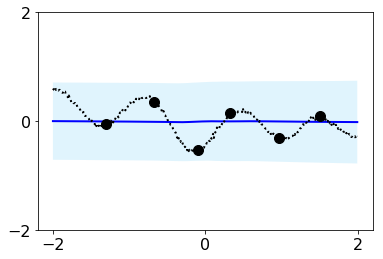

Iteration: 20000, loss: 0.44131994247436523


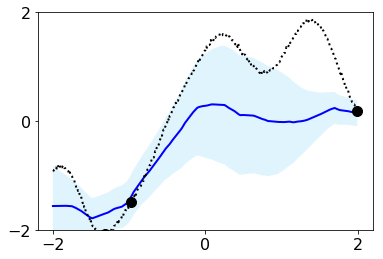

KeyboardInterrupt: 

In [10]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(TRAINING_ITERATIONS):
        sess.run(train_step)
        if i % PLOT_AFTER == 0:
            loss_value, pred_y, var, target_y, whole_query = sess.run(
                [loss, mu, sigma, data_test.target_y, data_test.query])

            (context_x, context_y), target_x = whole_query
            print('Iteration: {}, loss: {}'.format(i, loss_value))

            plot_functions(target_x, target_y, context_x, context_y, pred_y, var)